# Descrizione lessico ELIta
Il lessico comprende 6905 elementi, tra parole ed emoji. 

Il set di dati contiene il: 
* 21% di aggettivi, 
* il 50% di nomi, 
* il 21% di verbi,
* l'8% di parole che possono essere considerate sia aggettivi che nomi. 

Inoltre, è stato incluso un numero minore di avverbi, espressioni (ad esempio, "restare a bocca aperta" significa "guardare a bocca aperta") e interiezioni (ad esempio, "beh", "boh"). 

La raccolta dei dati ha comportato un processo di annotazione che includeva sia l'associazione delle parole alle emozioni 8 di base (Plutchik), utilizzando una scala da: 
* "non associato" (0), 
* "debolmente associato" (0,25), 
* "moderatamente associato" (0,75),
* "fortemente associato" (1), 

sia la valutazione degli elementi in base alle 3 dimensioni VAD (valenza, eccitazione e dominanza) utilizzando una scala da 1 a 9. 

Ognuna delle 6905 parole/emoji presenti nel lessico ha da un minimo di 5 a un massimo di 10 annotazioni (in media 5,13 annotazioni per parola).

Il lessico è fornito in diverse versioni:
* **RAW**, contiene **tutte** le annotazioni originali fatte dai partecipanti, senza filtri o aggregazioni.
* **GOLDEN**, versione **pulita** della RAW. Sono state selezionate:
    * le 5 annotazioni più simili tra loro per parola,
    * più 1 riga generata automaticamente, "Golden Standard", calcolata dalla moda delle 5 annotazioni migliori.
* **INTENSITY**, versione **aggregata continua**.\
Ogni parola ha una record per emozione (sono state aggiunte: **amore**, media tra gioia e fiducia, e **neutrale**) e dimensione VAD (13 in totale), con la media delle annotazioni selezionate nella versione GOLDEN.
* **BINARY**, versione **aggregata discreta**.\
Converte le annotazioni continue della versione INTENSITY in valori binari (0 o 1) utilizzando una soglia di 0,5.

# Scelta della versione del lessico per la visualizzazione
Per l'obbiettivo di visualizzazione del lessico ELIta con metodi distribuzionali, è stata scelta la versione **INTENSITY** del lessico. 

La ragione, per questa decisione, è che perché INTENSITY fornisce punteggi continui aggregati, necessari per calcolare le distanze semantiche precise tra le parole nello spazio vettoriale PCA/SVD.

Il file è fornito in modo che ci sia una riga per ogni coppia parola-emozione, contenente la media delle annotazioni.\
  Per l'analisi PCA, questo formato verrà trasformato in una matrice vettoriale dove ogni parola ha un unico vettore di punteggi per le 8 emozioni di base (Gioia, Tristezza, Rabbia, Disgusto, Paura, Fiducia, Sorpresa, Anticipazione) più le dimensioni VAD (Valenza, Attivazione, Dominanza) e le categorie aggiuntive (Amore, Neutrale).

# Caricamento e preparazione dati per l'utilizzo
Importiamo il file ELIta_INTENSITY.txt come un DataFrame di pandas. \
Dato che il file non presenta le intestazioni delle colonne, le definiamo qui manualmente. Ciò faciliterà i passaggi successivi.

In [1]:
import pandas as pd

intensityData = pd.read_csv("../ELIta_INTENSITY.txt", sep=',', header=None, names=['parola', 'emozione', 'valore'])
intensityData.head()

,parola,emozione,valore
0,‼,gioia,0.71
1,‼,tristezza,0.12
2,‼,rabbia,0.67
3,‼,disgusto,0.04
4,‼,paura,0.17


## Verifica integrità dati
Controllo valori unici nelle colonne 'parola' ed 'emozione' per confermare che il dataset sia stato caricato correttamente.

In [2]:
unique_words = intensityData['parola'].nunique()
unique_emotions = intensityData['emozione'].nunique()
print(f"Numero di parole uniche: {unique_words}")
print(f"Numero di emozioni/dimensioni uniche: {unique_emotions}")

Numero di parole uniche: 6905
Numero di emozioni/dimensioni uniche: 13


Controllo per valori mancanti nel DataFrame.

In [3]:
total_nulls = intensityData.isnull().sum().sum()
print(f"Totale valori mancanti nel dataset: {total_nulls}")

Totale valori mancanti nel dataset: 0


## Trasformazione del DataFrame in una matrice vettoriale
Manipolazione del dataset in una matrice per avere una riga per ogni parola e una colonna per ogni emozione/dimensione.

In [4]:
pivotedData = intensityData.pivot(index='parola', columns='emozione', values='valore')
pivotedData.head()

emozione,amore,aspettativa,attivazione,disgusto,dominanza,fiducia,gioia,neutrale,paura,rabbia,sorpresa,tristezza,valenza
parola,,,,,,,,,,,,,
????,0.08,0.17,7.00,0.17,4.33,0.04,0.12,0.0,0.17,0.42,0.79,0.42,5.17
a_caso,0.04,0.21,5.00,0.08,3.00,0.04,0.04,0.0,0.54,0.29,0.83,0.21,4.33
a_malincuore,0.00,0.12,5.50,0.21,3.67,0.00,0.00,0.0,0.21,0.21,0.04,0.83,3.33
a_scanso_di,0.21,0.58,5.33,0.04,4.67,0.25,0.17,0.0,0.17,0.42,0.21,0.25,5.00
abbagliante,0.32,0.62,7.00,0.00,6.50,0.17,0.46,0.0,0.12,0.12,0.71,0.04,6.67


## Salvataggio della matrice vettoriale
Salviamo la matrice vettoriale in un file CSV per utilizzi futuri.

In [5]:
pivotedData.to_csv("ELIta_INTENSITY_Matrix.csv")

---

# Visualizzazione tramite Riduzione Dimensionale (PCA e TruncatedSVD).
La matrice a 13 dimensioni (8 emozioni + 2 extra + 3 VAD) appena creata verrà schiacciata in 2 dimensioni per poterla disegnare su un piano 2D.

Due tecniche di riduzione dimensionale verranno utilizzate per questo scopo:
* **PCA (Principal Component Analysis)**: una tecnica classica che proietta i dati in uno spazio a bassa dimensione mantenendo la massima varianza possibile.
* **TruncatedSVD (Singular Value Decomposition)**: simile alla PCA, ma più efficiente per matrici sparse.

Entrambi i metodi ci permetteranno di visualizzare le parole in uno spazio 2D, dove la vicinanza tra i punti riflette la somiglianza emotiva tra le parole.

## Preparazione specifica per la visualizzazione
Prima di applicare PCA e TruncatedSVD, dobbiamo prendere alcune decisioni su come strutturare i dati per l'analisi:

1. **Selezionare le feature**: per la visualizzazione delle "parole in base all'emozione", è meglio usare:
    - prima, solo le 8 emozioni di base di Plutchik.
    - sucessivamente, aggiungere le 2 emozioni extra (amore e neutrale).
    - poi, le 3 dimensioni VAD.
    - infine, tutte le 13 feature insieme.

    Le analisi verranno fatte separatamente per ogni set di feature.
   
2. **Gestire le emoji**: il lessico contiene sia parole testuali che emoji. Per una visualizzazione più chiara, è meglio separare le due categorie e fare analisi distinte.
    - Prima analizzeremo solo le parole.
    - Poi faremo un'analisi separata per le emoji.

3. *Calcolare l'emozione dominante*: ci serve per colorare i punti nel grafico (es. colorare di rosso le parole di "rabbia").

## Separazione dei Dati (Emoji vs Parole)

In [6]:
import emoji
import plotly.io as pio

pio.renderers.default = "notebook_connected"

def is_likely_emoji(text):
    return emoji.emoji_count(str(text)) > 0

pivotedData['is_emoji'] = [is_likely_emoji(x) for x in pivotedData.index]

df_only_emojis = pivotedData[pivotedData['is_emoji'] == True].copy()
df_only_words = pivotedData[pivotedData['is_emoji'] == False].copy()

print(f"Totale elementi: {len(pivotedData)}")
print(f"Numero di Emoji trovate: {len(df_only_emojis)}")
print(f"Numero di Parole testuali: {len(df_only_words)}")

Totale elementi: 6905
Numero di Emoji trovate: 186
Numero di Parole testuali: 6719


In [7]:
df_only_emojis.head()

emozione,amore,aspettativa,attivazione,disgusto,dominanza,fiducia,gioia,neutrale,paura,rabbia,sorpresa,tristezza,valenza,is_emoji
parola,,,,,,,,,,,,,,
‼,0.35,0.17,6.67,0.04,5.17,0.00,0.71,0.0,0.17,0.67,0.83,0.12,5.00,True
⁉,0.11,0.21,7.67,0.04,5.50,0.04,0.17,0.0,0.29,0.17,0.71,0.08,4.33,True
☠,0.15,0.04,6.00,0.46,5.50,0.12,0.17,0.0,0.67,0.54,0.17,0.58,3.83,True
☹,0.02,0.12,5.83,0.08,3.50,0.04,0.00,0.0,0.21,0.17,0.04,1.00,2.67,True
☺,0.73,0.50,6.17,0.00,7.00,0.54,0.92,0.0,0.00,0.00,0.62,0.00,7.33,True


In [8]:
df_only_words.head()

emozione,amore,aspettativa,attivazione,disgusto,dominanza,fiducia,gioia,neutrale,paura,rabbia,sorpresa,tristezza,valenza,is_emoji
parola,,,,,,,,,,,,,,
????,0.08,0.17,7.00,0.17,4.33,0.04,0.12,0.0,0.17,0.42,0.79,0.42,5.17,False
a_caso,0.04,0.21,5.00,0.08,3.00,0.04,0.04,0.0,0.54,0.29,0.83,0.21,4.33,False
a_malincuore,0.00,0.12,5.50,0.21,3.67,0.00,0.00,0.0,0.21,0.21,0.04,0.83,3.33,False
a_scanso_di,0.21,0.58,5.33,0.04,4.67,0.25,0.17,0.0,0.17,0.42,0.21,0.25,5.00,False
abbagliante,0.32,0.62,7.00,0.00,6.50,0.17,0.46,0.0,0.12,0.12,0.71,0.04,6.67,False


## Visualizzazione delle Emoji (PCA)


### Visualizzazione PCA per le 8 Emozioni di Base
Il seguente codice esegue la PCA sulle emoji basandosi solo sulle 8 emozioni di base e crea un grafico con due visualizzazioni affiancate: una con le emoji come testo e l'altra con marker colorati.


In [9]:
from Visualizzazione.emotion_config import EMOTION_COLORS, BASIC_EMOTIONS, ALL_EMOTIONS, VAD_FEATURES
from Visualizzazione.pca_utils import perform_pca_analysis 
from Visualizzazione.visualizer import plot_pca_emotions

dominant_basic = df_only_emojis[BASIC_EMOTIONS].fillna(0).idxmax(axis=1)
pca_basic = perform_pca_analysis(df_only_emojis, BASIC_EMOTIONS, dominant_basic)

fig1 = plot_pca_emotions(
    pca_data=pca_basic,
    colors_dict={k: v for k, v in EMOTION_COLORS.items() if k in BASIC_EMOTIONS},
    title="PCA: Distribuzione Emoji (8 Emozioni Base)"
)
fig1.show()

---


### Visualizzazione PCA per le 10 Emozioni (8 di base + 2 extra)

In [10]:
dominant_all = df_only_emojis[ALL_EMOTIONS].fillna(0).idxmax(axis=1)
pca_all = perform_pca_analysis(df_only_emojis, ALL_EMOTIONS, dominant_all)

fig2 = plot_pca_emotions(
    pca_data=pca_all,
    colors_dict=EMOTION_COLORS, # Usa tutti i colori
    title="PCA Emoji: Spazio a 10 Emozioni (+ Amore e Neutrale)"
)
fig2.show()

---

### Visualizzazione PCA per le 3 Dimensioni VAD, senza standirdizzazione
Senza standardizzazione, per vedere l'effetto delle scale originali (1-9).

In [11]:
pca_vad = perform_pca_analysis(df_only_emojis, VAD_FEATURES, dominant_all, scale=False)

fig3 = plot_pca_emotions(
    pca_data=pca_vad,
    colors_dict=EMOTION_COLORS,
    title="PCA: Proiezione VAD (Valenza, Arousal, Dominance)",
    plot_loadings=True,
    feature_names=['Valenza', 'Attivazione', 'Dominanza']
)
fig3.show()

---


### Visualizzazione PCA per le 3 Dimensioni VAD, con standirdizzazione
Con standardizzazione, per portare le scale 1-9 su una scala comparabile (z-score).

In [12]:
pca_vad_scaled = perform_pca_analysis(df_only_emojis, VAD_FEATURES, dominant_all, scale=True)

fig4 = plot_pca_emotions(
    pca_data=pca_vad_scaled,
    colors_dict=EMOTION_COLORS,
    title="PCA: Proiezione VAD Standardizzata (Z-Score)",
    plot_loadings=True,
    feature_names=['Valenza', 'Attivazione', 'Dominanza']
)
fig4.show()

---

### Visualizzazione PCA VAD 3D

In [13]:
from visualizer import plot_pca_3d

pca_vad_3d = perform_pca_analysis(
    df=df_only_emojis, 
    features_columns=VAD_FEATURES, 
    dominant_emotions=dominant_all, 
    scale=True,        
    n_components=3     
)

fig_3d = plot_pca_3d(
    pca_data=pca_vad_3d,
    colors_dict=EMOTION_COLORS,
    title="Spazio Emotivo 3D (Derivato da VAD)"
)

fig_3d.show()

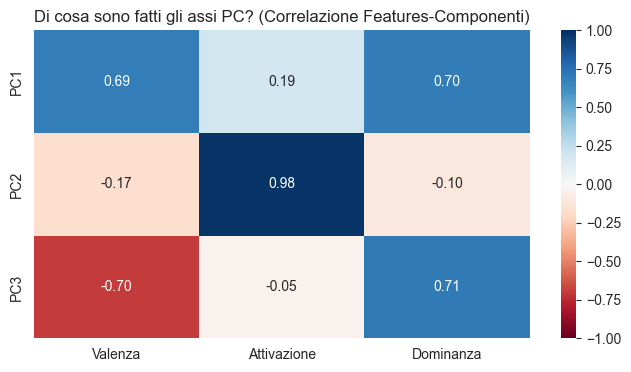

      Valenza  Attivazione  Dominanza
PC1  0.691202     0.190445   0.697116
PC2 -0.166901     0.980640  -0.102415
PC3 -0.703125    -0.045560   0.709606


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_obj = pca_vad_3d['pca_object']
components = pca_obj.components_

loadings_df = pd.DataFrame(
    components,
    columns=['Valenza', 'Attivazione', 'Dominanza'],
    index=['PC1', 'PC2', 'PC3']
)

plt.figure(figsize=(8, 4))
sns.heatmap(loadings_df, annot=True, cmap='RdBu', center=0, fmt='.2f', vmin=-1, vmax=1)
plt.title("Di cosa sono fatti gli assi PC? (Correlazione Features-Componenti)")
plt.show()

print(loadings_df)

### Visualizzazione PCA per tutte le 13 Feature

In [15]:
hybrid_features = ALL_EMOTIONS + VAD_FEATURES

pca_hybrid = perform_pca_analysis(
    df=df_only_emojis, 
    features_columns=hybrid_features, 
    dominant_emotions=dominant_all, 
    scale=True
)

fig5 = plot_pca_emotions(
    pca_data=pca_hybrid,
    colors_dict=EMOTION_COLORS,
    title="PCA Ibrida: Relazione tra Emozioni Discrete e Dimensioni VAD",
    plot_loadings=True,
    feature_names=hybrid_features 
)

fig5.show()

#TODO: perchè è stato aggiunto neutrale?

## Visualizzazione delle Emoji (metodi diversi)

### t-SNE

In [16]:
from Visualizzazione.pca_utils import perform_tsne_analysis

hybrid_features = ALL_EMOTIONS + VAD_FEATURES

# Perplexity: gioca con questo numero (tra 5 e 50).
# 30 è lo standard. Se vedi una palla informe, prova ad abbassarlo.
tsne_data = perform_tsne_analysis(
    df=df_only_emojis, 
    features_columns=hybrid_features, 
    dominant_emotions=dominant_all, 
    perplexity=25,  # Prova 15, 25, 40
    scale=True      # t-SNE funziona meglio con dati scalati
)

fig_tsne = plot_pca_emotions(
    pca_data=tsne_data,
    colors_dict=EMOTION_COLORS,
    title="t-SNE: Clustering non-lineare delle Emoji (13 Feature)",
    plot_loadings=False # Non ha senso vettori in t-SNE
)

fig_tsne.show()

In [17]:
from Visualizzazione.pca_utils import perform_tsne_analysis 

hybrid_features = ALL_EMOTIONS

# Perplexity: gioca con questo numero (tra 5 e 50).
# 30 è lo standard. Se vedi una palla informe, prova ad abbassarlo.
tsne_data = perform_tsne_analysis(
    df=df_only_emojis, 
    features_columns=hybrid_features, 
    dominant_emotions=dominant_all, 
    perplexity=25,  # Prova 15, 25, 40
    scale=True      # t-SNE funziona meglio con dati scalati
)

fig_tsne = plot_pca_emotions(
    pca_data=tsne_data,
    colors_dict=EMOTION_COLORS,
    title="t-SNE: Clustering non-lineare delle Emoji (10 Feature)",
    plot_loadings=False # Non ha senso vettori in t-SNE
)

fig_tsne.show()

In [18]:
from Visualizzazione.pca_utils import perform_tsne_analysis # Importa la nuova funzione

hybrid_features = VAD_FEATURES

# Perplexity: gioca con questo numero (tra 5 e 50).
# 30 è lo standard. Se vedi una palla informe, prova ad abbassarlo.
tsne_data = perform_tsne_analysis(
    df=df_only_emojis, 
    features_columns=hybrid_features, 
    dominant_emotions=dominant_all, 
    perplexity=25,  # Prova 15, 25, 40
    scale=True      # t-SNE funziona meglio con dati scalati
)

fig_tsne = plot_pca_emotions(
    pca_data=tsne_data,
    colors_dict=EMOTION_COLORS,
    title="t-SNE: Clustering non-lineare delle Emoji (3 VAD)",
    plot_loadings=False # Non ha senso vettori in t-SNE
)

fig_tsne.show()

### TruncatedSVD

In [19]:
from Visualizzazione.pca_utils import perform_svd_analysis

hybrid_features = ALL_EMOTIONS + VAD_FEATURES

# Nota: Non stiamo scalando i dati qui. SVD vedrà l'intensità grezza.
svd_data = perform_svd_analysis(
    df=df_only_emojis, 
    features_columns=hybrid_features, 
    dominant_emotions=dominant_all
)

fig_svd = plot_pca_emotions(
    pca_data=svd_data,
    colors_dict=EMOTION_COLORS,
    title="TruncatedSVD: Visualizzazione Emoji (13 Feature)",
    plot_loadings=True, # SVD ha i vettori (components_), quindi possiamo disegnarli!
    feature_names=hybrid_features
)

fig_svd.show()

In [20]:
from Visualizzazione.pca_utils import perform_svd_analysis

hybrid_features = ALL_EMOTIONS

# Nota: Non stiamo scalando i dati qui. SVD vedrà l'intensità grezza.
svd_data = perform_svd_analysis(
    df=df_only_emojis, 
    features_columns=hybrid_features, 
    dominant_emotions=dominant_all
)

fig_svd = plot_pca_emotions(
    pca_data=svd_data,
    colors_dict=EMOTION_COLORS,
    title="TruncatedSVD: Visualizzazione Emoji (10 Feature)",
    plot_loadings=True, # SVD ha i vettori (components_), quindi possiamo disegnarli!
    feature_names=hybrid_features
)

fig_svd.show()

In [21]:
from Visualizzazione.pca_utils import perform_svd_analysis

hybrid_features = VAD_FEATURES

# Nota: Non stiamo scalando i dati qui. SVD vedrà l'intensità grezza.
svd_data = perform_svd_analysis(
    df=df_only_emojis, 
    features_columns=hybrid_features, 
    dominant_emotions=dominant_all
)

fig_svd = plot_pca_emotions(
    pca_data=svd_data,
    colors_dict=EMOTION_COLORS,
    title="TruncatedSVD: Visualizzazione Emoji (3 VAD)",
    plot_loadings=True, # SVD ha i vettori (components_), quindi possiamo disegnarli!
    feature_names=hybrid_features
)

fig_svd.show()